# LSTM-FCN Final Training and Evaluation

This notebook trains LSTM-FCN with the best hyperparameters found during tuning and evaluates on the test set.

**Task**: Multiclass fault classification (18 classes)

**Data Split**:
- Train: Model fitting
- Validation: Early stopping monitoring
- Test: Final evaluation (never seen during training)

**Architecture**: LSTM branch + FCN branch with hierarchical dilated convolutions

**Outputs**:
- Trained model: `outputs/models/lstm_fcn_final.pt`
- Metrics: `outputs/metrics/lstm_fcn_metrics.json`
- Confusion matrix: `outputs/figures/lstm_fcn_confusion_matrix.png`

## Configuration

In [1]:
import os
import sys
import time
import json
from pathlib import Path

start_time = time.time()

# Quick mode configuration
QUICK_MODE = os.getenv('QUICK_MODE', 'False').lower() in ('true', '1', 'yes')

# Paths
DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../outputs')
HYPERPARAM_DIR = OUTPUT_DIR / 'hyperparams'
MODEL_DIR = OUTPUT_DIR / 'models'
METRICS_DIR = OUTPUT_DIR / 'metrics'
FIGURES_DIR = OUTPUT_DIR / 'figures'

MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
MODE_SUFFIX = '_quick' if QUICK_MODE else ''

# Setup progress logging
LOG_FILE = OUTPUT_DIR / f'lstm_fcn_final_progress{MODE_SUFFIX}.log'

def log(msg):
    """Log message to both stdout and file."""
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
    full_msg = f"[{timestamp}] {msg}"
    print(full_msg)
    with open(LOG_FILE, 'a') as f:
        f.write(full_msg + '\n')

# Clear log file at start
with open(LOG_FILE, 'w') as f:
    f.write('')

log("="*60)
log("LSTM-FCN Final Training and Evaluation")
log("="*60)

if QUICK_MODE:
    TRAIN_FRACTION = 0.01
    MAX_EPOCHS = 1
    PATIENCE = 1
    log("🚀 QUICK MODE (1% data, 1 epoch)")
else:
    TRAIN_FRACTION = 1.0
    MAX_EPOCHS = 100
    PATIENCE = 10
    log("🔬 FULL MODE (100% data, up to 100 epochs)")

# Load best hyperparameters (prefer full mode, fall back to quick)
if (HYPERPARAM_DIR / 'lstm_fcn_best.json').exists():
    hp_file = HYPERPARAM_DIR / 'lstm_fcn_best.json'
    log("Using FULL mode hyperparameters")
else:
    hp_file = HYPERPARAM_DIR / 'lstm_fcn_best_quick.json'
    log("Using QUICK mode hyperparameters")

with open(hp_file) as f:
    hp_data = json.load(f)
    best_params = hp_data['best_params']

log(f"Hyperparameters: {best_params}")
log("="*60)

[2026-01-05 14:22:46] ============================================================
[2026-01-05 14:22:46] LSTM-FCN Final Training and Evaluation
[2026-01-05 14:22:46] ============================================================
[2026-01-05 14:22:46] 🔬 FULL MODE (100% data, up to 100 epochs)
[2026-01-05 14:22:46] Using FULL mode hyperparameters
[2026-01-05 14:22:46] Hyperparameters: {'sequence_length': 40, 'lstm_hidden': 24, 'lstm_layers': 1, 'dropout': 0.4365806189303844, 'learning_rate': 0.0013924522400597294, 'batch_size': 64}
[2026-01-05 14:22:46] ============================================================


## Imports

In [2]:
print("\n[Step 1/6] Loading libraries...")
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log(f"✓ Using device: {device}")


[Step 1/6] Loading libraries...


[2026-01-05 14:22:50] ✓ Using device: cuda


## Data Loading and Preprocessing

In [3]:
print("\n[Step 2/6] Loading datasets...")
data_load_start = time.time()

train = pd.read_csv(DATA_DIR / 'multiclass_train.csv')
val = pd.read_csv(DATA_DIR / 'multiclass_val.csv')
test = pd.read_csv(DATA_DIR / 'multiclass_test.csv')

log(f"✓ Train: {train.shape}")
log(f"✓ Val: {val.shape}")
log(f"✓ Test: {test.shape}")
log(f"✓ Data loading time: {time.time() - data_load_start:.2f}s")

features = [col for col in train.columns if 'xmeas' in col or 'xmv' in col]
num_features = len(features)
log(f"✓ Number of features: {num_features}")

# Subsample if in quick mode (subsample runs, not random rows, to preserve sequences)
if TRAIN_FRACTION < 1.0:
    train_runs = train[['faultNumber', 'simulationRun']].drop_duplicates()
    val_runs = val[['faultNumber', 'simulationRun']].drop_duplicates()
    
    n_train_runs = max(1, int(len(train_runs) * TRAIN_FRACTION))
    n_val_runs = max(1, int(len(val_runs) * TRAIN_FRACTION))
    
    sampled_train_runs = train_runs.sample(n=n_train_runs, random_state=RANDOM_SEED)
    sampled_val_runs = val_runs.sample(n=n_val_runs, random_state=RANDOM_SEED)
    
    train = train.merge(sampled_train_runs, on=['faultNumber', 'simulationRun'])
    val = val.merge(sampled_val_runs, on=['faultNumber', 'simulationRun'])
    
    log(f"✓ Subsampled train to {TRAIN_FRACTION*100:.1f}%: {train.shape}")
    log(f"✓ Subsampled val to {TRAIN_FRACTION*100:.1f}%: {val.shape}")

# Fit scaler on training data only
scaler = StandardScaler()
scaler.fit(train[features])

# Fit label encoder on ALL possible fault classes (not just subsampled data)
# TEP has faults 0-20, excluding 3, 9, 15 (which don't exist), giving 18 classes
ALL_FAULT_CLASSES = [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20]
label_encoder = LabelEncoder()
label_encoder.fit(ALL_FAULT_CLASSES)
num_classes = len(label_encoder.classes_)
class_names = [str(int(c)) for c in label_encoder.classes_]
log(f"✓ Number of classes: {num_classes}")


[Step 2/6] Loading datasets...


[2026-01-05 14:23:05] ✓ Train: (864000, 57)
[2026-01-05 14:23:05] ✓ Val: (432000, 57)
[2026-01-05 14:23:05] ✓ Test: (2880000, 57)
[2026-01-05 14:23:05] ✓ Data loading time: 15.20s
[2026-01-05 14:23:05] ✓ Number of features: 52


[2026-01-05 14:23:06] ✓ Number of classes: 18


## Model and Dataset Definition

In [4]:
print("\n[Step 3/6] Defining model and dataset...")

class SimulationRunDataset(Dataset):
    """Dataset that creates windows WITHIN simulation runs only."""
    def __init__(self, df, features, scaler, label_encoder, sequence_length=10):
        self.seq_len = sequence_length
        self.windows = []
        self.labels = []
        
        for (fault, run), group in df.groupby(['faultNumber', 'simulationRun']):
            group = group.sort_values('sample')
            X = scaler.transform(group[features].values)
            y = label_encoder.transform(group['faultNumber'].values)
            
            for i in range(len(X) - sequence_length + 1):
                self.windows.append(X[i:i+sequence_length])
                self.labels.append(y[i+sequence_length-1])
        
        self.windows = np.array(self.windows, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.windows[idx]), torch.tensor(self.labels[idx])

class LSTMFCN(nn.Module):
    """LSTM-FCN: Combines LSTM with 1D CNN for time series classification.
    
    Architecture matches v1/LSTM_FCN_final.ipynb:
    - Hierarchical conv filters (32→24→16) 
    - Dilation rates (1→2→4) for multi-scale feature extraction
    - SpatialDropout after first conv layer
    """
    def __init__(self, input_size, lstm_hidden, lstm_layers, dropout, num_classes):
        super().__init__()
        
        # LSTM branch
        self.lstm = nn.LSTM(input_size, lstm_hidden, lstm_layers,
                           batch_first=True, dropout=dropout if lstm_layers > 1 else 0)
        
        # FCN branch with hierarchical filters and dilation
        self.conv1 = nn.Conv1d(input_size, 32, kernel_size=7, padding='same', dilation=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.spatial_dropout = nn.Dropout2d(0.3)
        
        self.conv2 = nn.Conv1d(32, 24, kernel_size=5, padding='same', dilation=2)
        self.bn2 = nn.BatchNorm1d(24)
        
        self.conv3 = nn.Conv1d(24, 16, kernel_size=3, padding='same', dilation=4)
        self.bn3 = nn.BatchNorm1d(16)
        
        self.gap = nn.AdaptiveAvgPool1d(1)
        
        # Classifier head
        combined_dim = lstm_hidden + 16
        hidden_dim = max(32, num_classes * 2)
        self.fc1 = nn.Linear(combined_dim, hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        # LSTM branch: (batch, seq, features)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        
        # FCN branch: (batch, features, seq)
        x_cnn = x.permute(0, 2, 1)
        
        x_cnn = torch.relu(self.bn1(self.conv1(x_cnn)))
        x_cnn = self.spatial_dropout(x_cnn.unsqueeze(-1)).squeeze(-1)
        
        x_cnn = torch.relu(self.bn2(self.conv2(x_cnn)))
        x_cnn = torch.relu(self.bn3(self.conv3(x_cnn)))
        
        x_cnn = self.gap(x_cnn).squeeze(-1)
        
        combined = torch.cat([lstm_out, x_cnn], dim=1)
        out = torch.relu(self.fc1(combined))
        out = self.dropout(out)
        return self.fc2(out)

log("✓ Model and dataset classes defined")


[Step 3/6] Defining model and dataset...
[2026-01-05 14:23:06] ✓ Model and dataset classes defined


In [5]:
print("\n[Step 4/6] Creating datasets...")
dataset_start = time.time()

sequence_length = best_params['sequence_length']
batch_size = best_params['batch_size']

# Create separate datasets for train, val, and test
train_dataset = SimulationRunDataset(train, features, scaler, label_encoder, sequence_length)
val_dataset = SimulationRunDataset(val, features, scaler, label_encoder, sequence_length)
test_dataset = SimulationRunDataset(test, features, scaler, label_encoder, sequence_length)

log(f"✓ Train dataset: {len(train_dataset)} windows")
log(f"✓ Val dataset: {len(val_dataset)} windows")
log(f"✓ Test dataset: {len(test_dataset)} windows")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

log(f"✓ Dataset creation time: {time.time() - dataset_start:.2f}s")


[Step 4/6] Creating datasets...


[2026-01-05 14:23:24] ✓ Train dataset: 793800 windows
[2026-01-05 14:23:24] ✓ Val dataset: 396900 windows
[2026-01-05 14:23:24] ✓ Test dataset: 2739600 windows
[2026-01-05 14:23:24] ✓ Dataset creation time: 18.16s


## Model Training

In [6]:
print("\n[Step 5/6] Training final model with early stopping on validation set...")
train_start = time.time()

model = LSTMFCN(
    input_size=num_features,
    lstm_hidden=best_params['lstm_hidden'],
    lstm_layers=best_params['lstm_layers'],
    dropout=best_params['dropout'],
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# Training with early stopping on validation loss
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
history = {'train_loss': [], 'val_loss': [], 'epoch': []}

log(f"Training for up to {MAX_EPOCHS} epochs with patience {PATIENCE}...")

for epoch in range(MAX_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['epoch'].append(epoch + 1)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        log(f"Epoch {epoch+1}/{MAX_EPOCHS}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")
    
    # Early stopping on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            log(f"Early stopping at epoch {epoch+1}")
            break

# Restore best model
if best_model_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

train_time = time.time() - train_start
best_epoch = history['epoch'][history['val_loss'].index(min(history['val_loss']))]
print(f"\n✓ Training complete in {train_time:.2f}s ({epoch+1} epochs)")
log(f"✓ Best epoch: {best_epoch} (val_loss = {best_val_loss:.6f})")


[Step 5/6] Training final model with early stopping on validation set...


[2026-01-05 14:23:25] Training for up to 100 epochs with patience 10...


[2026-01-05 14:24:42] Epoch 1/100: Train Loss = 0.236754, Val Loss = 0.080427


[2026-01-05 14:29:39] Epoch 5/100: Train Loss = 0.045451, Val Loss = 0.046184


[2026-01-05 14:35:44] Epoch 10/100: Train Loss = 0.039680, Val Loss = 0.034567


[2026-01-05 14:41:37] Epoch 15/100: Train Loss = 0.032395, Val Loss = 0.042950


[2026-01-05 14:47:24] Epoch 20/100: Train Loss = 0.030047, Val Loss = 0.043743


[2026-01-05 14:49:38] Early stopping at epoch 22

✓ Training complete in 1574.03s (22 epochs)
[2026-01-05 14:49:38] ✓ Best epoch: 12 (val_loss = 0.033670)


## Evaluation on Test Set

In [7]:
print("\n[Step 6/6] Evaluating on test set...")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

y_test = np.array(all_labels)
y_pred = np.array(all_preds)

accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')

print(f"\n{'='*60}")
print(f"TEST SET RESULTS {'(QUICK MODE)' if QUICK_MODE else ''}")
print(f"{'='*60}")
print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Balanced Accuracy: {balanced_acc:.4f} ({balanced_acc*100:.2f}%)")
print(f"F1 (weighted):     {f1_weighted:.4f}")
print(f"F1 (macro):        {f1_macro:.4f}")
print(f"Precision (weighted): {precision_weighted:.4f}")
print(f"Recall (weighted):    {recall_weighted:.4f}")
print(f"{'='*60}")


[Step 6/6] Evaluating on test set...



TEST SET RESULTS 
Accuracy:          0.9937 (99.37%)
Balanced Accuracy: 0.9937 (99.37%)
F1 (weighted):     0.9937
F1 (macro):        0.9937
Precision (weighted): 0.9938
Recall (weighted):    0.9937


In [8]:
print("\nPer-Class Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


Per-Class Classification Report:


              precision    recall  f1-score   support

           0     0.9523    0.9946    0.9730    152200
           1     0.9986    0.9999    0.9992    152200
           2     0.9991    1.0000    0.9996    152200
           4     0.9998    0.9998    0.9998    152200
           5     0.9987    1.0000    0.9993    152200
           6     1.0000    1.0000    1.0000    152200
           7     1.0000    1.0000    1.0000    152200
           8     0.9983    0.9937    0.9960    152200
          10     0.9970    0.9909    0.9939    152200
          11     1.0000    0.9997    0.9998    152200
          12     0.9885    0.9648    0.9765    152200
          13     0.9966    0.9853    0.9909    152200
          14     1.0000    1.0000    1.0000    152200
          16     0.9994    0.9978    0.9986    152200
          17     0.9986    0.9941    0.9964    152200
          18     0.9655    0.9759    0.9707    152200
          19     0.9988    0.9994    0.9991    152200
          20     0.9974    

## Visualizations

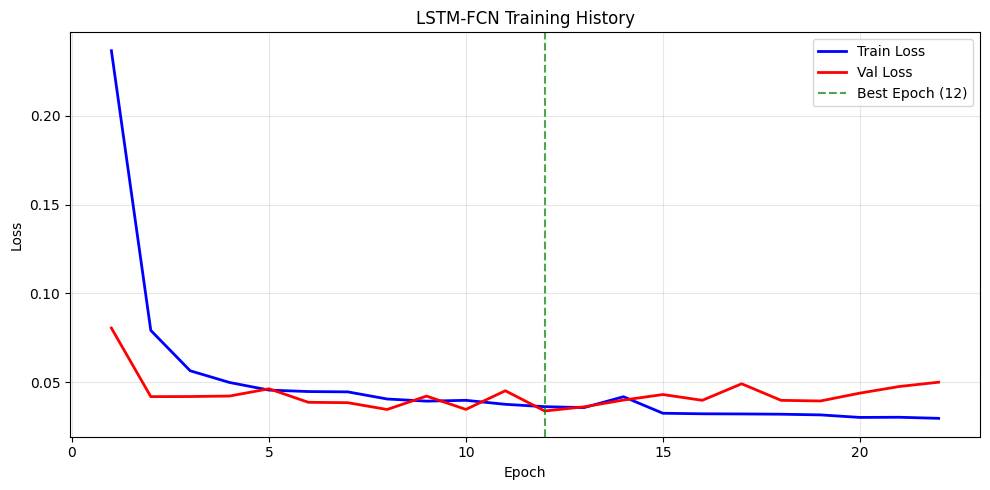

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history['epoch'], history['train_loss'], 'b-', linewidth=2, label='Train Loss')
ax.plot(history['epoch'], history['val_loss'], 'r-', linewidth=2, label='Val Loss')
ax.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'LSTM-FCN Training History{" - QUICK" if QUICK_MODE else ""}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / f'lstm_fcn_training_history{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()

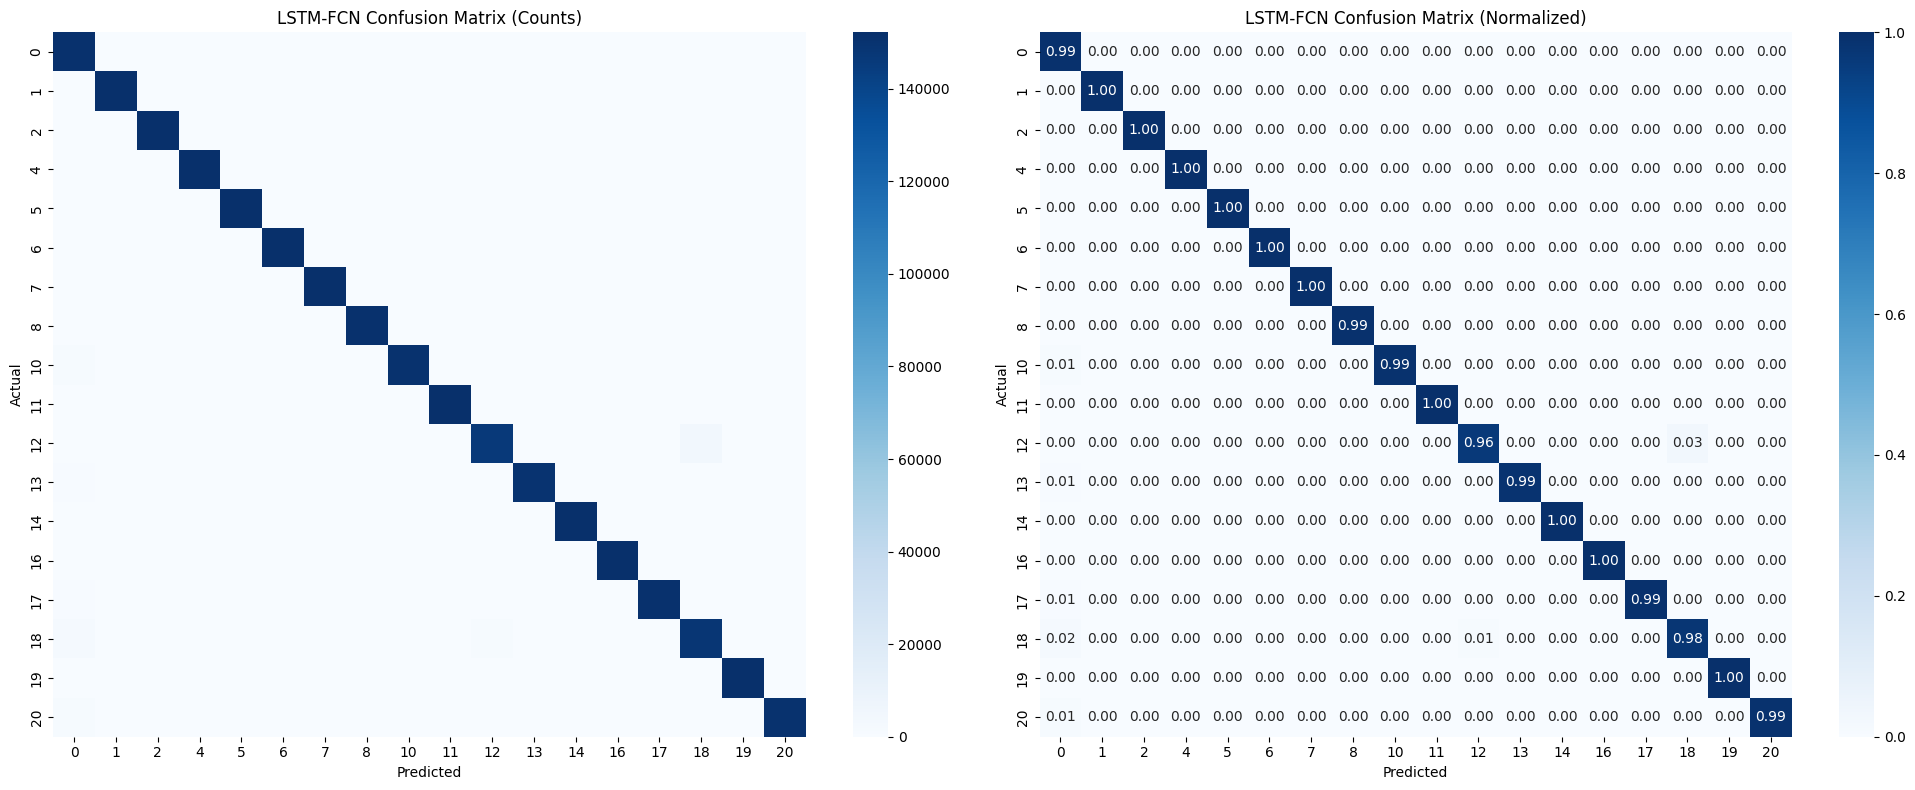

[2026-01-05 14:50:59] ✓ Saved confusion matrix to ../outputs/figures/lstm_fcn_confusion_matrix.png


In [10]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'LSTM-FCN Confusion Matrix (Counts){" - QUICK" if QUICK_MODE else ""}')

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'LSTM-FCN Confusion Matrix (Normalized){" - QUICK" if QUICK_MODE else ""}')

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'lstm_fcn_confusion_matrix{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()
log(f"✓ Saved confusion matrix to {FIGURES_DIR / f'lstm_fcn_confusion_matrix{MODE_SUFFIX}.png'}")

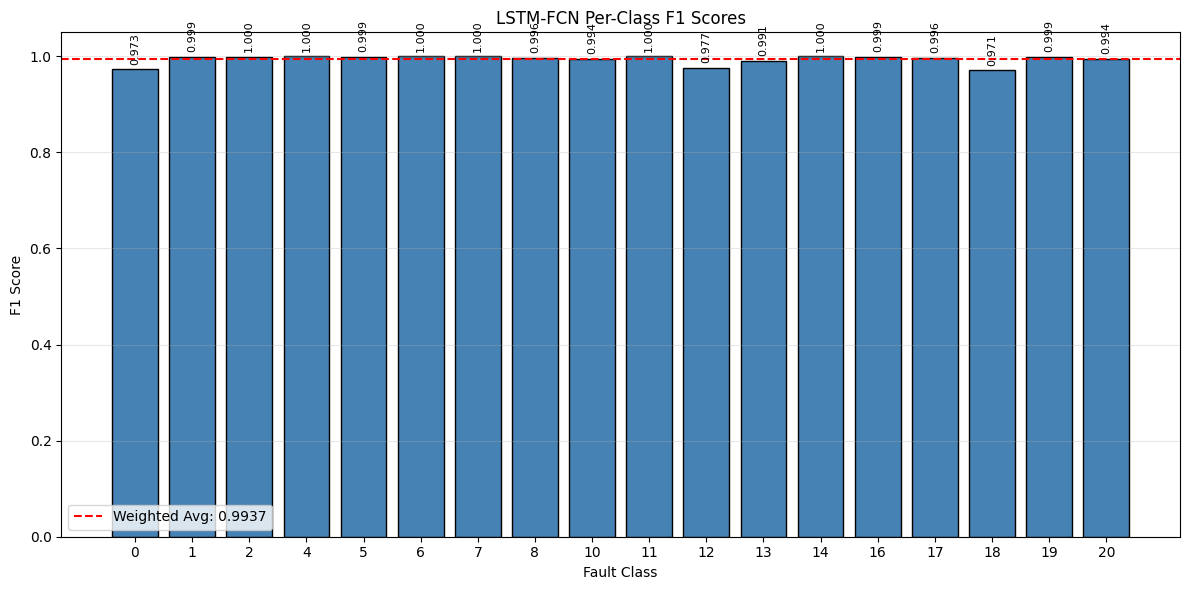

In [11]:
f1_per_class = f1_score(y_test, y_pred, average=None)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(class_names, f1_per_class, color='steelblue', edgecolor='black')
ax.axhline(y=f1_weighted, color='red', linestyle='--', label=f'Weighted Avg: {f1_weighted:.4f}')
ax.set_xlabel('Fault Class')
ax.set_ylabel('F1 Score')
ax.set_title(f'LSTM-FCN Per-Class F1 Scores{" - QUICK" if QUICK_MODE else ""}')
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bar, f1 in zip(bars, f1_per_class):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{f1:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'lstm_fcn_per_class_f1{MODE_SUFFIX}.png', dpi=150, bbox_inches='tight')
plt.show()

## Save Results

In [12]:
end_time = time.time()
total_runtime = end_time - start_time

metrics = {
    'model': 'LSTM-FCN',
    'task': 'multiclass',
    'quick_mode': QUICK_MODE,
    'train_fraction': TRAIN_FRACTION,
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'test_samples': len(test_dataset),
    'best_epoch': best_epoch,
    'best_val_loss': float(best_val_loss),
    'accuracy': float(accuracy),
    'balanced_accuracy': float(balanced_acc),
    'f1_weighted': float(f1_weighted),
    'f1_macro': float(f1_macro),
    'precision_weighted': float(precision_weighted),
    'recall_weighted': float(recall_weighted),
    'per_class_f1': {class_names[i]: float(f1_per_class[i]) for i in range(num_classes)},
    'hyperparameters': best_params,
    'epochs_trained': len(history['epoch']),
    'training_time_seconds': float(train_time),
    'total_runtime_seconds': float(total_runtime),
    'random_seed': RANDOM_SEED
}

with open(METRICS_DIR / f'lstm_fcn_metrics{MODE_SUFFIX}.json', 'w') as f:
    json.dump(metrics, f, indent=2)
log(f"✓ Saved metrics to {METRICS_DIR / f'lstm_fcn_metrics{MODE_SUFFIX}.json'}")

torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_size': num_features,
        'lstm_hidden': best_params['lstm_hidden'],
        'lstm_layers': best_params['lstm_layers'],
        'num_classes': num_classes,
        'dropout': best_params['dropout'],
        'sequence_length': sequence_length
    },
    'scaler_mean': scaler.mean_.tolist(),
    'scaler_scale': scaler.scale_.tolist(),
    'label_encoder_classes': label_encoder.classes_.tolist(),
    'features': features
}, MODEL_DIR / f'lstm_fcn_final{MODE_SUFFIX}.pt')
log(f"✓ Saved model to {MODEL_DIR / f'lstm_fcn_final{MODE_SUFFIX}.pt'}")

cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df.to_csv(METRICS_DIR / f'lstm_fcn_confusion_matrix{MODE_SUFFIX}.csv')
log(f"✓ Saved confusion matrix to {METRICS_DIR / f'lstm_fcn_confusion_matrix{MODE_SUFFIX}.csv'}")

print(f"\n{'='*60}")
log(f"✓ LSTM-FCN Final Training Complete! {'(QUICK MODE)' if QUICK_MODE else ''}")
print(f"{'='*60}")
log(f"Total runtime: {int(total_runtime // 60)}m {int(total_runtime % 60)}s")
log(f"Best epoch: {best_epoch}")
log(f"Test Accuracy: {accuracy:.4f}")
log(f"Test F1 (weighted): {f1_weighted:.4f}")
print(f"{'='*60}")

[2026-01-05 14:50:59] ✓ Saved metrics to ../outputs/metrics/lstm_fcn_metrics.json
[2026-01-05 14:50:59] ✓ Saved model to ../outputs/models/lstm_fcn_final.pt
[2026-01-05 14:50:59] ✓ Saved confusion matrix to ../outputs/metrics/lstm_fcn_confusion_matrix.csv

[2026-01-05 14:50:59] ✓ LSTM-FCN Final Training Complete! 
[2026-01-05 14:50:59] Total runtime: 28m 13s
[2026-01-05 14:50:59] Best epoch: 12
[2026-01-05 14:50:59] Test Accuracy: 0.9937
[2026-01-05 14:50:59] Test F1 (weighted): 0.9937
